<small><i>This notebook was put together by [Abel Meneses-Abad](http://www.menesesabad.com) for Paper *Paraphrase Beyond Sentence*. Source and license info is on [GitHub](https://github.com/sorice/2017paraphrasebsent/).</i></small>

# Preprocessing Data

Having a normalized corpus or a fiturized corpus, the first step is to normalize, clean, scale those features. In Big Data the number of features (or # of columns) is always exponential. For example 35 features in 5M rows runs ok in a laptop, but only incrementing to 40 features the problem could be considered Big Data [<a href="#Bilbro2019" title="Visual Diagnostics at Scale"> (Bilbro2019) </a>](#Bilbro2019).

Feature Selection it is impossible or problematic, some times, without scaling or cleanning the data properly. As you will see at the end of this chapter, the number of features doesn't increase mandatory the accuracy of Machine Learning models. In order to incrase the future number of useful features those not-important must be detected and eliminated.

In [98]:
%matplotlib inline
# use seaborn plotting style defaults
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import time
import pandas as pd
import textsim
len(textsim.__all_distances__)

43

## From CSV to Sklearn Bunch

Loading csv file in Sklearn style.

In [2]:
import csv
import numpy as np
from sklearn.utils import Bunch

with open('data/MSRPC-2004/msrpc.csv') as csv_file:
    data_file = csv.reader(csv_file)
    temp = next(data_file)
    n_samples = int(temp[0])
    n_features = int(temp[1])
    target_names = np.array(temp[2:4])
    temp = next(data_file)
    feature_names = np.array(temp[:-2])
    data = np.empty((n_samples, n_features))
    target = np.empty((n_samples), dtype=np.int)
    index = np.empty((n_samples), dtype=np.int)
    
    for i, ir in enumerate(data_file):
        data[i] = np.asarray(ir[:-2], dtype=np.float)
        target[i] = np.asarray(ir[-1], dtype=np.int)
        index[i] = np.asarray(ir[-2], dtype=np.int)

    fdescr = 'Microsoft Research Corpus'
        
msrpc = Bunch(data=data, target=target,
    target_names=target_names,
    DESCR=fdescr,
    feature_names=feature_names)

x = msrpc['data']
Y = msrpc['target']

In [3]:
data.shape

(5786, 43)

In [4]:
msrpc.target

array([1, 1, 1, ..., 0, 0, 1])

In [5]:
feature_names,len(feature_names)

(array(['binary_distance', 'braycurtis_distance', 'canberra_distance',
        'chebyshev_distance', 'containment_distance',
        'correlation_distance', 'cosine_distance',
        'damerau_levenshtein_distance', 'dice_coefficient',
        'dice_distance', 'edit_similarity', 'euclidean_distance',
        'hamming_distance', 'interval_distance', 'jaccard_distance',
        'jaro_distance', 'jaro_winkler_distance', 'kulsinski_distance',
        'lcs_distance', 'lcs_similarity', 'levenshtein_distance',
        'mahalanobis_distance', 'manhattan_distance', 'masi_distance',
        'match_rating_comparison', 'matching_coefficient',
        'matching_coefficient_pablo', 'matching_distance',
        'minkowski_distance', 'needleman_wunsch_distance',
        'needleman_wunsch_similarity', 'overlap_distance',
        'qgram_distance', 'rogerstanimoto_distance', 'russellrao_distance',
        'seuclidean_distance', 'smith_waterman_distance',
        'sokalmichener_distance', 'sokalsneath_dis

In [6]:
print(x.mean(),Y[:20])

nan [1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1]


**Note:** The mean value can't be obtained due to *'NaN'* values inside data.

## Imputing missing values

Read the page 102 of the book "Python Machine Learning Unlock deeper insights ..." [<a href="#Raschka2015" title="Python Machine Learning Book"> (Raschka2015) </a>](#Raschka2015).

After some experiments we consider better to convert numpy.array in a pandas.DataFrame structure because can be useful to change *Nan* values by the median or mean of the column when the value is, this kind of operation with np is not possible (np.where and pd.where are differents).

In [7]:
df = pd.DataFrame(msrpc.data, columns=msrpc.feature_names, index=index)

In [8]:
#Finding null values
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

,correlation_distance,seuclidean_distance,yule_distance
16,1.0,3.464102,NaN
35,1.0,4.000000,NaN
161,0.0,NaN,0.5
176,1.0,4.690416,NaN
217,NaN,3.162278,NaN
...,...,...,...
5651,1.0,4.472136,NaN
5730,1.0,4.472136,NaN
5759,1.0,4.000000,NaN
5763,1.0,5.477226,NaN


In [9]:
#Replacing, but still problems
df.replace(np.nan, df.mean(), inplace=True)
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

,yule_distance
16,NaN
35,NaN
176,NaN
217,NaN
228,NaN
...,...
5651,NaN
5730,NaN
5759,NaN
5763,NaN


In [10]:
#Replacing inf by max and -inf by min
mask = df['yule_distance'] != np.inf
df.loc[~mask, 'yule_distance'] = df.loc[mask, 'yule_distance'].max()
bmask = df['yule_distance'] != -np.inf
df.loc[~bmask, 'yule_distance'] = df.loc[bmask, 'yule_distance'].min()

In [11]:
#Replacing inf and -inf by the mean of the rest of the values
is_inf = df.yule_distance == np.inf 
is_ninf = df.yule_distance == -np.inf
yule_mean = df.yule_distance[~is_inf & ~is_ninf].mean()
print(yule_mean)

1.3010968741795017


In [12]:
#Replacing, the inf & -inf by the mean of the rest
df.replace([np.inf, -np.inf], df.yule_distance[~is_inf & ~is_ninf].mean(), inplace=True)
print(df.mean())
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

binary_distance                   0.000000
braycurtis_distance               0.341267
canberra_distance                11.244317
chebyshev_distance                1.179571
containment_distance              0.756179
correlation_distance              1.073415
cosine_distance                   0.687943
damerau_levenshtein_distance     52.452471
dice_coefficient                  0.589374
dice_distance                     0.219358
edit_similarity                   0.565265
euclidean_distance                3.442548
hamming_distance                105.863118
interval_distance                11.561182
jaccard_distance                  0.564055
jaro_distance                     0.765100
jaro_winkler_distance             0.802584
kulsinski_distance                0.348925
lcs_distance                     84.088144
lcs_similarity                    0.709653
levenshtein_distance             52.492223
mahalanobis_distance              8.794717
manhattan_distance               11.985482
masi_distan

,yule_distance
16,NaN
35,NaN
176,NaN
217,NaN
228,NaN
...,...
5651,NaN
5730,NaN
5759,NaN
5763,NaN


For some reason the yule_distance still have __NaN__ values. So in the next block this problem is fixed writing directly to the cells with those values.

In [14]:
df.loc[row_mask,col_mask] = yule_mean
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

""


Here also you can experiment that pd.DataFrame interpolation and fillna, ffill, all those methods fail when remain some inf or -inf values.

    df.interpolate()
    
OR    

    df.fillna(method='ffill')
    
OR

    df.fillna(dff.mean())

Originally this classical method with sklearn was implemented but (read the note)
```python
from sklearn.impute import SimpleImputer
imr = SimpleImputer(missing_values=NaN, strategy='mean')
imr = imr.fit(x)
X = imr.transform(x)
print(X.shape)
```
(5786, 42)

**Note:** After some experiments was discovered a shape change in the data matrix because of the *Imputer* method. This change of shape isn't commented in any readed book until now. Imputer method is showed here because it is the classic example.

## Feature Scaling

Transforming all features to the same scale.

In [19]:
from sklearn.preprocessing import scale
X = df
# A varian & Recomended: scale the data such that mean = 0 and standard deviation = 1
# see "Python Machine Learning Unlock deeper insights ..." (Raschka2015), pag 111, first paragrah.
X_s = scale(X,with_mean=True,with_std=True,axis=0)

# B variant: Second way to scale
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_s2 = mms.fit_transform(X)

# C variant & Recomended: Same as way A
# see "Python Machine Learning Unlock deeper insights ..." (Raschka2015), pag 111, first paragrah.
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_s3 = stdsc.fit_transform(X)

print(np.max(X_s2), np.max(X_s3))

1.0000000000000002 19.270003160896454


In [39]:
type(X)

pandas.core.frame.DataFrame

In [68]:
X_s.shape, X_s2.shape

((5786, 43), (5786, 43))

### Saving Data

In [92]:
#saving obtained clean data for future notebooks
import pickle
data = [X_s, Y]
positive_split_scaled_data = [X_s2, Y, msrpc.feature_names, index]
pickle.dump(data, open('data/cleaned-scaled-data.pkl', 'wb'))
pickle.dump(positive_split_scaled_data, open('data/clean-scaled-positive-data.pkl', 'wb'))

## Feature Selection

Read the page 118 of the book "Python Machine Learning Unlock deeper insights ..." (Raschka2015).

In [43]:
from sklearn import feature_selection
from sklearn.feature_selection import chi2

In [70]:
#Note: SelectKBest doesn't work with none positive values, we use x_s2 for that reason.
X_n = feature_selection.SelectKBest(chi2, k=10).fit_transform(x_s2, Y)

In [71]:
X_n.shape

(5786, 10)

In [46]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
class SBS():
    def __init__(self, estimator, k_features,
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size,
                                    random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                    X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                            X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train,
                            X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [103]:
data10 = open('data/strat-split-data10.pkl', 'rb')
Xn_train, Xn_test, Yn_train, Yn_test = pickle.load(data10)
data32 = open('data/strat-split-data32.pkl', 'rb')
Xnn_train, Xnn_test, Ynn_train, Ynn_test = pickle.load(data32)

In [110]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression(max_iter=200, n_jobs=4, multi_class='ovr')

#from sklearn.svm import LinearSVC
#clf = LinearSVC()

sbs = SBS(knn, k_features=1)
sbs.fit(X_train, Y_train)

Result of training the same LinearSVC classifier

    Xs,Ys = 163.21618843078613
    Xn,Yn = 168.56555843353271
    Xnn,Ynn = 168.5159306526184

In [106]:
sbs.scores_.index(max(sbs.scores_))

14

In [108]:
sbs

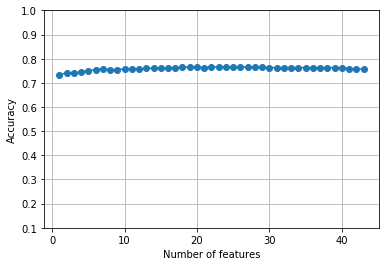

In [109]:
sns.reset_orig()
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.1, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [79]:
#the maximun occurs at subset 11
j = list(sbs.subsets_[11])
print( len(j), feature_names[j])

32 ['binary_distance' 'braycurtis_distance' 'canberra_distance'
 'chebyshev_distance' 'containment_distance' 'correlation_distance'
 'cosine_distance' 'damerau_levenshtein_distance' 'dice_coefficient'
 'dice_distance' 'hamming_distance' 'jaccard_distance' 'jaro_distance'
 'jaro_winkler_distance' 'lcs_distance' 'lcs_similarity'
 'levenshtein_distance' 'mahalanobis_distance' 'manhattan_distance'
 'match_rating_comparison' 'matching_coefficient_pablo'
 'matching_distance' 'minkowski_distance' 'needleman_wunsch_distance'
 'needleman_wunsch_similarity' 'overlap_distance' 'qgram_distance'
 'seuclidean_distance' 'smith_waterman_distance' 'sokalsneath_distance'
 'sqeuclidean_distance' 'yule_distance']


In [95]:
columns = []
for i,_ in enumerate(feature_names[j]):
    columns.append(i)
Xnn = X_s2[:,columns]

In [96]:
Xnn.shape

(5786, 32)

## Feature Importance

Code from page 124 of the book "Python Machine Learning Unlock deeper insights ..." (Raschka2015).

**Note**: This kind of evaluation of features, just assigned a rank to distances, but no group them or rerank it to get the most N important features.

In [86]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=4)
forest.fit(Xs_train, Ys_train)
importances = forest.feature_importances_

In [88]:
Xs_train.shape[1]

43

In [87]:
indices = np.argsort(importances)[::-1]
for f in range(Xs_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[f], importances[indices[f]]))

 1) binary_distance                0.049808
 2) braycurtis_distance            0.043350
 3) canberra_distance              0.043117
 4) chebyshev_distance             0.043052
 5) containment_distance           0.042951
 6) correlation_distance           0.042676
 7) cosine_distance                0.040153
 8) damerau_levenshtein_distance   0.033034
 9) dice_coefficient               0.032839
10) dice_distance                  0.031639
11) edit_similarity                0.027538
12) euclidean_distance             0.026245
13) hamming_distance               0.025378
14) interval_distance              0.023923
15) jaccard_distance               0.023620
16) jaro_distance                  0.023535
17) jaro_winkler_distance          0.023519
18) kulsinski_distance             0.023471
19) lcs_distance                   0.023377
20) lcs_similarity                 0.022867
21) levenshtein_distance           0.022291
22) mahalanobis_distance           0.021558
23) manhattan_distance          

In [97]:
#saving obtained feature selected clean data for future notebooks
data10 = [X_n, Y]
data32 = [Xnn, Y]
pickle.dump(data10, open('data/clean-scaled-fselect10-data.pkl', 'wb'))
pickle.dump(data32, open('data/clean-scaled-fselect32-data.pkl', 'wb'))

# Conclusions

The data preparation is a very important step in Machine Learning process. Its understanding implied full knowledge of file operations, data behaviour, math implications of missing or non-scaled values, the validation process implications with train and test data, outliers significance and feature selection importance to improve the accuracy of our models.

Section *model evaluation example* shows that with only 10 features is possible to get results over 0.74 in accuracy metric.

# Recomendations

* Read about **unregularized models** where *dimensionality reduction* via feature selection, is an alternative way to reduce the complexity of the model and avoid overfitting.

* Study the way to introduce Stritified Kfold data in real experiments to fix the seeds and make comparable the results between different classifiers. [see 4.4](04.4-Classification) for kfold analysis of multiple classifiers.

* Sklearn Bunch is a more complicated structure than pandas.

* The feature importance process it is not relaiable, the importance order is the same initial order.

# Questions

* Test feature selection in sparse data with linear models like Lasso or Logistic Regresion.
* Use the class SelectFromModel inside feature_selection module, and try different classification models like svm, knn, etc.
* Make a secuence of feature selection with SVM and a set of kernels like RBF ('rbf'), Gram Matrix ('precomputed'), Cosine('cosine'), 'linear', Polinomial('poly'), Sigmoid and a self kernel. Compare the selected features and their rank. 

# References and Resources

* Rebecca Bilbro, "Visual Diagnostics at Scale". SciPy Conference, 2019.
<a id='Bilbro2019'></a>

* Sebastian Raschka, Book "Python Machine Learning". Packt Publishing, 2015.
<a id='Raschka2015'></a>

* Gopi Subramanian, Book "Python Data Science Cookbook". Packt Publishing, 2015.
<a id='Subramanian2015'></a>

* Alberto Boschetti & Luca Massaron, Book "Python Data Science Essential". Packt Publishing, 2015.
<a id='Boschetti2015'></a>

* Trent Hauck, Book "Scikit-learn Cookbook". Packt Publishing, 2014.
<a id='Hauck2015'></a>